# Analysis of NGC 3627 with Optical + X-ray wavelength data

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astroquery.mast import Observations

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, mad_std

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry

import shutil
import glob
import os 

cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"

# Mosaicking
## Querying data with astroquery

In [7]:
filters = ["F275W", "F336W", "F438W", "F555W", "F814W"]
obs_id = [13364, 13477, 15654, 12968]

print("Finding observations for WFC3/UVIS images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="HST",
                                        filters=filters,
                                        proposal_id=obs_id, instrument_name="WFC3/UVIS")
print("Done")

Finding observations for WFC3/UVIS images...
Done


In [8]:
obs_table

<Table masked=True length=32>
intentType obs_collection provenance_name ...   objID1       distance     
   str7         str3            str7      ...    str9        float64      
---------- -------------- --------------- ... --------- ------------------
   science            HST          CALWF3 ... 770402919 28.036980630951845
   science            HST         HAP-SVM ... 656236841  27.75725548690898
   science            HST         HAP-SVM ... 653027433                0.0
   science            HST          CALWF3 ... 760221178                0.0
   science            HST          CALWF3 ... 766019247                0.0
   science            HST         HAP-SVM ... 660111522                0.0
   science            HST         HAP-SVM ... 656236786 27.744534966031452
   science            HST         HAP-SVM ... 653027656                0.0
   science            HST         HAP-SVM ... 658533718                0.0
       ...            ...             ... ...       ...                ...
   science            HST         HAP-SVM ... 658533651                0.0
   science            HST         HAP-SVM ... 660111518                0.0
   science            HST         HAP-SVM ... 660111529                0.0
   science            HST         HAP-SVM ... 660111535                0.0
   science            HST          CALWF3 ... 755619047  27.68408894925479
   science            HST          CALWF3 ... 765924476  27.68408894925479
   science            HST         HAP-SVM ... 660111537                0.0
   science            HST         HAP-SVM ... 653027580                0.0
   science            HST         HAP-SVM ... 656236664 24.461193653384154
   science            HST          CALWF3 ... 770884879                0.0

In [9]:
%%time
cd(hstdir)
print("Downloading data.\nThis may take several minutes... \n")
products = Observations.get_product_list(obs_table)
data_prod = ['FLC']       
data_type = ['HAP-SVM']   

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")


This may take several minutes... 

INFO: 52 of 104 products were duplicates. Only returning 52 unique product(s). [astroquery.mast.utils]
Done
CPU times: user 20.9 s, sys: 17.5 s, total: 38.3 s
Wall time: 4min 6s


In [11]:
# Gathering the FLC file names
input_flcs = glob.glob(os.path.join('mastDownload','HST','*','*.fits'))

# Moving files from mastDownload directory into current directory
for flc in input_flcs:
  shutil.copy(flc, os.path.basename(flc))

shutil.rmtree('mastDownload') # removes the extra directories
print("Done")

Done


In [13]:
flc_files = glob.glob("hst*_acs_wfc_*_j*_flc.fits")
flc_files.sort()       # Alphabetizing files

for i,f in enumerate(flc_files):
    try: hdu = fits.open(f)
    except: print(f,"not good. Please remove.")

## F555W
The following code will be run in a python terminal

In [ ]:
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

flc_files = glob.glob("*f555w*flc*.fits")
flc_files.sort()

adriz(flc_files, output='M66_mosaic_uvis_f555w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False)  

# F814W

In [ ]:
flc_files = glob.glob("*f814w*flc*.fits")
flc_files.sorqqt()

adriz(flc_files, output='M66_mosaic_uvis_f814w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False) 

# F438W

In [ ]:
flc_files = glob.glob("*f438w*flc*.fits")
flc_files.sort()

adriz(flc_files, output='M66_mosaic_uvis_f438w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False) 

# F336W

In [ ]:
flc_files = glob.glob("*f336w*flc*.fits")
flc_files.sort()

adriz(flc_files, output='M66_mosaic_uvis_f336w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False) 

# F275W

In [ ]:
flc_files = glob.glob("*f275w*flc*.fits")
flc_files.sort()

adriz(flc_files, output='M66_mosaic_uvis_f275w',
      preserve=True, clean=True, context=False,
      skymethod='globalmin+match', # renormalizes the brightness of each field
      driz_cr=True, driz_cr_corr=False,
      final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=False, build=False) 

# Photometry

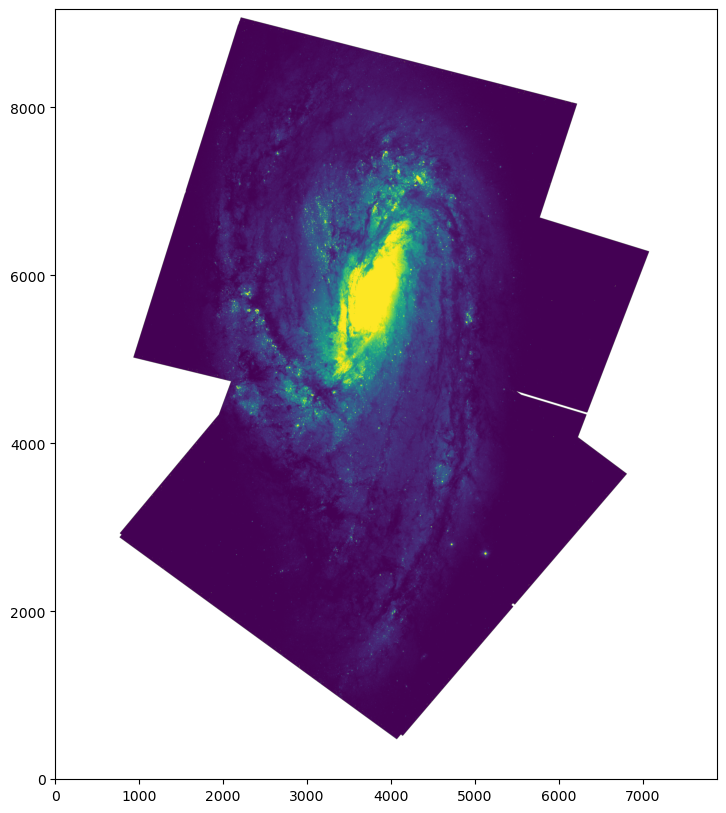

In [74]:
cd(hstdir)
hdu = fits.open("M66_mosaic_uvis_f555w_drc_sci.fits")
plt.figure(figsize=(10,10))
plt.imshow(hdu[0].data, origin='lower',
          vmin=0, vmax=0.8)

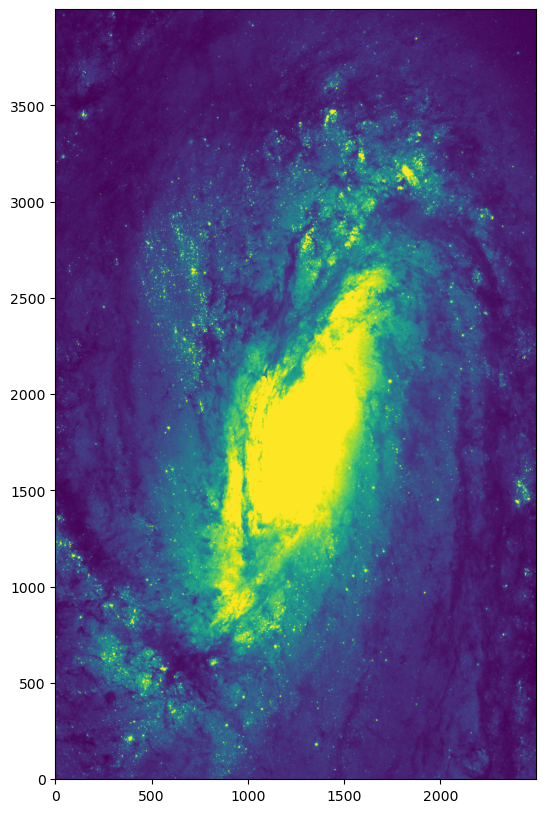

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(hdu[0].data[4000:8000, 2500:5000], origin='lower',
          vmin=0, vmax=0.8)

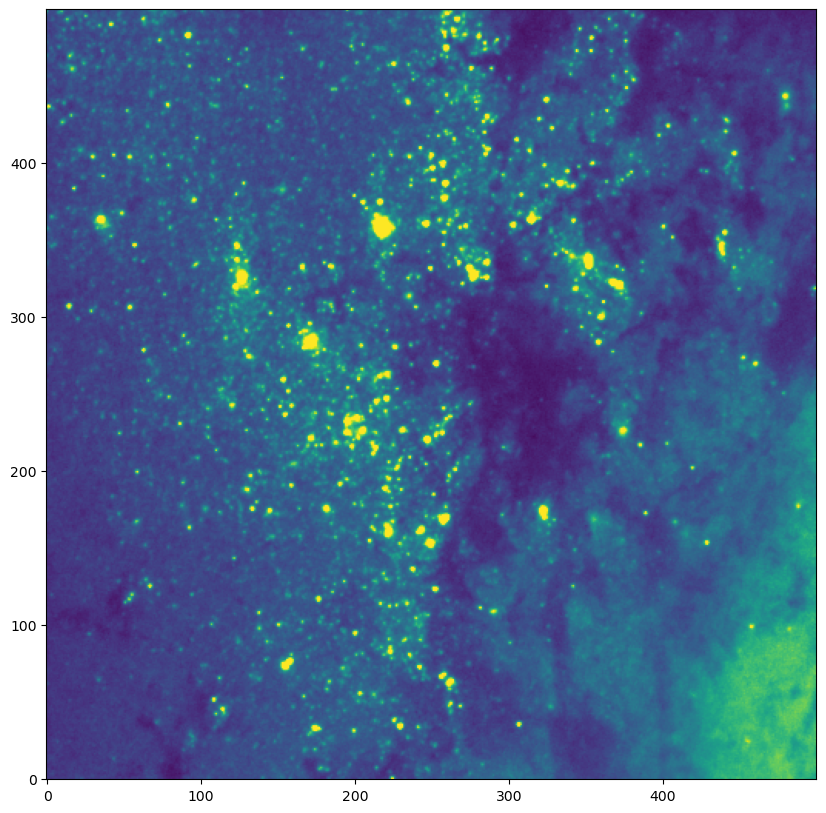

In [77]:
plt.figure(figsize=(10,10))
plt.imshow(hdu[0].data[6000:6500, 3000:3500], origin='lower',
          vmin=0, vmax=0.8)

In [95]:
hdu = fits.open("M66_mosaic_uvis_f555w_drc_sci.fits")
subset = hdu[0].data[6000:6500, 3000:3500].astype(float)
subset -= np.median(subset)
bg_sig = mad_std(subset)

# define parameters
fwhm = 3.0
threshold = 1.5 * bg_sig 

print("FWHM used:", fwhm, 
      "Threshold used:", threshold)

daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
daosource = daofind(subset)
positions = np.transpose((daosource["xcentroid"], \
                          daosource["ycentroid"]))

# Create apertures around sources
apertures = CircularAperture(positions, r=5) 
# Plotting
plt.figure(figsize=(10,10))
plt.imshow(subset, cmap="gray_r", origin="lower", \
          vmin=0, vmax=0.3)
apertures.plot(color="limegreen", lw=1)
plt.show()

FWHM used: 3.0 Threshold used: 0.1118339255809463


FWHM used: 4.0 Threshold used: 0.18638987596824386


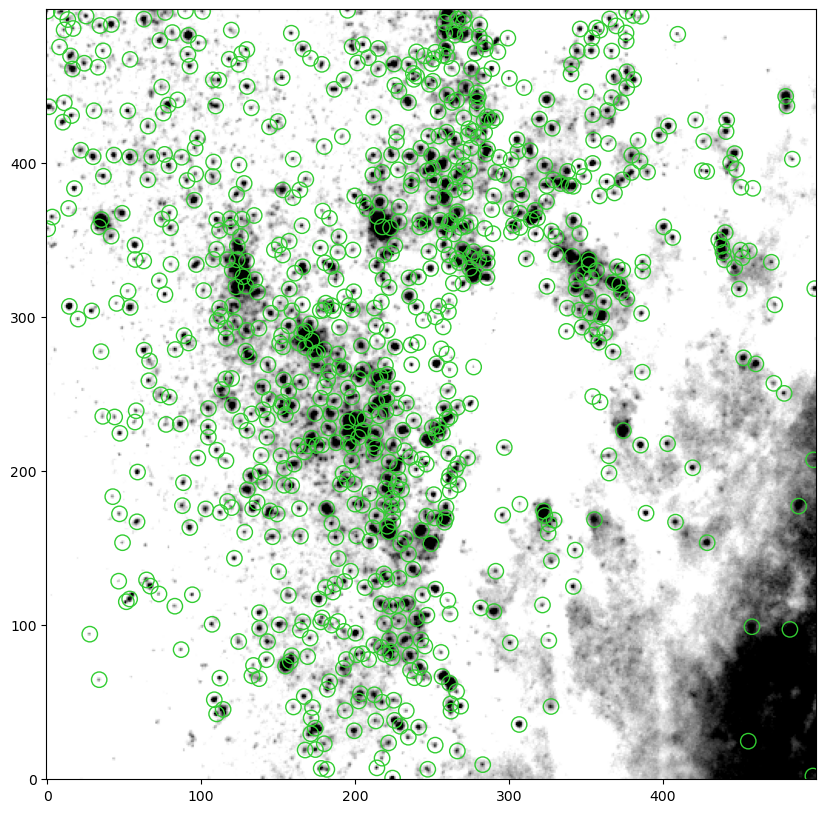

In [106]:
hdu = fits.open("M66_mosaic_uvis_f555w_drc_sci.fits")
subset = hdu[0].data[6000:6500, 3000:3500].astype(float)
subset -= np.median(subset)
bg_sig = mad_std(subset)

# define parameters
fwhm = 4.0
threshold = 2.5 * bg_sig 

print("FWHM used:", fwhm, 
      "Threshold used:", threshold)

daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
daosource = daofind(subset)
positions = np.transpose((daosource["xcentroid"], \
                          daosource["ycentroid"]))

# Create apertures around sources
apertures = CircularAperture(positions, r=5) 
# Plotting
plt.figure(figsize=(10,10))
plt.imshow(subset, cmap="gray_r", origin="lower", \
          vmin=0, vmax=0.3)
apertures.plot(color="limegreen", lw=1)
plt.show()